In [113]:
# from google.colab import drive
# drive.mount('/content/drive/')

In [114]:
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from tqdm import tqdm
import networkx as nx
import scipy
import json
import sys
path = ''
sys.path.append(path)
import utils
import settings
import pickle
from sklearn.preprocessing import StandardScaler, Normalizer, RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

In [115]:
def save(nom,model):
  # Enregistrez le modele (ML/scaler/autre) dans un fichier
  with open(nom+'.pkl', 'wb') as f:
      pickle.dump(model, f)

In [116]:
def f_open(chemin):
  with open(chemin, 'rb') as f:
    modele = pickle.load(f)
  return modele

# Hyper params

In [117]:
train_delta_t = 0
max_depth = 4
eval_metric = 'mae'
n_estimators = 10000
scaler_name = 'Normalizer'
scaler_a = Normalizer()
scaler_b = Normalizer()
scaler_c = Normalizer()
random_state = 37
submission_path = 'random_set_sub/'

In [118]:
path = path
train_a, train_b, train_c, X_train_estimated_a, X_train_estimated_b, X_train_estimated_c, X_train_observed_a, X_train_observed_b, X_train_observed_c, X_test_estimated_a, X_test_estimated_b, X_test_estimated_c = utils.read_files(diff_path=path)
test = pd.read_csv(path+"test.csv")
sample_submission = pd.read_csv(path+"sample_submission.csv")

# B and C clean up

In [119]:
def filter_dates_when_constants(df, date_c = 'time', y = 'pv_measurement', delta = { 'days': 3 }):
    df = df.copy()
    mask_y_change = df[y] != df[y].shift(1)

    start_date = None
    end_date = None

    constant_periods = []

    for index, row in df.iterrows():
        if not mask_y_change[index]:
            if start_date is None:
                start_date = row[date_c]
            end_date = row[date_c]
        else:
            if start_date is not None and (end_date - start_date) >= pd.Timedelta(**delta):
                constant_periods.append((start_date, end_date))
            start_date = None
            end_date = None

    if start_date is not None and (end_date - start_date) >= pd.Timedelta(**delta):
        constant_periods.append((start_date, end_date))
    return constant_periods

In [120]:
def delete_date_range_from_df(df, dates, date_c = 'time'):
    df = df.copy()
    c = 0
    for start_date, end_date in dates:
        mask = (df[date_c] >= start_date) & (df[date_c] < end_date)
        df = df[~mask]
    df.reset_index(drop=True, inplace=True)
    return df

In [121]:
delta = { 'hours': 12 * 5}
train_a = delete_date_range_from_df(train_a, filter_dates_when_constants(train_a, delta=delta))
train_b = delete_date_range_from_df(train_b, filter_dates_when_constants(train_b, delta=delta))
train_c = delete_date_range_from_df(train_c, filter_dates_when_constants(train_c, delta=delta))

In [122]:
delta_title = str(train_delta_t)
delta_h = pd.Timedelta(minutes=train_delta_t)
train_a['date_forecast'] = train_a['time'] - delta_h
train_b['date_forecast'] = train_b['time'] - delta_h
train_c['date_forecast'] = train_c['time'] - delta_h

# Réorganisation des df :

In [123]:
# observed + estimated
X_total_a = pd.concat([X_train_observed_a,X_train_estimated_a])
X_total_b = pd.concat([X_train_observed_b,X_train_estimated_b])
X_total_c = pd.concat([X_train_observed_c,X_train_estimated_c])

Attention, il faut penser à revoir les valeurs météo et pv de estimated !!!

# Changement nom time dans les train

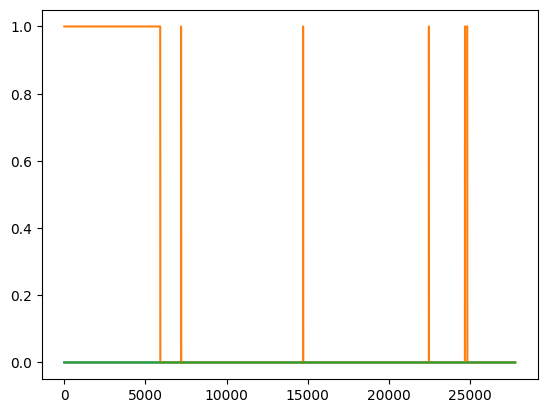

In [124]:
plt.plot(train_c.isna())

In [125]:
# train_a.rename(columns={'time': 'date_forecast'}, inplace=True) #pour faire le merge
# train_b.rename(columns={'time': 'date_forecast'}, inplace=True) #pour faire le merge
# train_c.rename(columns={'time': 'date_forecast'}, inplace=True) #pour faire le merge
# test.rename(columns={'time': 'date_forecast'}, inplace=True)
train_a, train_b, train_c = train_a.drop(columns='time'), train_b.drop(columns='time'), train_c.drop(columns='time')
train_a.dropna(subset=['pv_measurement'], inplace=True)  #Supprime les lignes vides
train_b.dropna(subset=['pv_measurement'], inplace=True)  #Supprime les lignes vides
train_c.dropna(subset=['pv_measurement'], inplace=True)  #Supprime les lignes vides

# Correspondance X et y :

Ici nous avons plusieurs choix :    
- matcher directement sur dateforcast
- matcher sur dateforcast et résumer nos variables météo en moyenne et écart type
- matcher sur un autre créneau (peut être fais sur des variables spécifique !)

Dans un premier temps on fera directement sur dateforcast

In [126]:
X_total_a_y = pd.merge(X_total_a, train_a, on='date_forecast', how='inner')
X_total_b_y = pd.merge(X_total_b, train_b, on='date_forecast', how='inner')
X_total_c_y = pd.merge(X_total_c, train_c, on='date_forecast', how='inner')

In [127]:
def gestion_nan(df):
  df_copy = df.copy()
  #delete of the snow density column
  df_copy = df_copy.drop('snow_density:kgm3',axis=1)
  # Approximation of the other two columns
  df_copy['ceiling_height_agl:m'] = df_copy['ceiling_height_agl:m'].interpolate(method='linear', limit_direction='both')
  df_copy['cloud_base_agl:m'] = df_copy['cloud_base_agl:m'].interpolate(method='linear', limit_direction='both')
  return df_copy

In [128]:
X_train_observed_a_nan = gestion_nan(X_train_observed_a)

# Traitement des df + séparation train/test

## Séparation train/test

A la fin on va projeter à partir de donnée météo estimer sur un periode non rencontré.

On va donc séparer notre train/test sur les même conditions, à savoir que le test sera issue de estimated. Il ne reste qu'à fixer la date à partir de laquelle on fait la séparation.

L'objectif est aussi d'avoir de l'estimated dans l'entrainement pour prendre en compte la différence entre observed et estimated qui devra être régler plus tard.

In [129]:
print(len(X_train_observed_a))
print(len(X_train_estimated_a))
print(len(X_train_estimated_a)/(len(X_train_estimated_a)+len(X_train_observed_a)))

118669
17576
0.12900289918896107


In [130]:
X_total_a_y_nan = gestion_nan(X_total_a_y)
X_total_b_y_nan = gestion_nan(X_total_b_y)
X_total_c_y_nan = gestion_nan(X_total_c_y)

In [131]:
split_date_a = X_train_estimated_a['date_forecast'].quantile(0.25)
split_date_b = X_train_estimated_b['date_forecast'].quantile(0.25)
split_date_c = X_train_estimated_c['date_forecast'].quantile(0.25)

In [132]:
split_date_a = pd.to_datetime("2021-04-15")
split_date2_a = pd.to_datetime("2021-08-15")

split_date_b = pd.to_datetime("2019-04-15")
split_date2_b = pd.to_datetime("2019-08-15")

split_date_c = pd.to_datetime("2021-04-15")
split_date2_c = pd.to_datetime("2021-08-15")

In [133]:
start_2019 = pd.to_datetime("2019-03-21")
end_2019 = pd.to_datetime("2019-09-22")

start_2020 = pd.to_datetime("2020-03-21")
end_2020 = pd.to_datetime("2020-09-22")

start_2021 = pd.to_datetime("2021-03-21")
end_2021 = pd.to_datetime("2021-09-22")

start_2022 = pd.to_datetime("2022-03-21")
end_2022 = pd.to_datetime("2022-09-22")

In [134]:
def create_mask_for_split_training_and_testing(df, start_estimated, time_column = 'date_forecast'):
    mask_2019 = ((df[time_column] >= start_2019) & (df[time_column] < end_2019))
    mask_2020 = ((df[time_column] >= start_2020) & (df[time_column] < end_2020))
    mask_2021 = ((df[time_column] >= start_2021) & (df[time_column] < end_2021))
    mask_2022 = ((df[time_column] >= start_2022) & (df[time_column] < end_2022))
    mask_estimated = (df[time_column] >= start_estimated)
    return mask_2019, mask_2020, mask_2021, mask_2022,mask_estimated

In [135]:
def split_training_testing_set(df, start_estimated, random_state=42, text_size = .1):
    df_to_split = df.copy()
    mask_2019, mask_2020, mask_2021, mask_2022, mask_estimated = create_mask_for_split_training_and_testing(df_to_split, start_estimated)
    df_summers = df_to_split[mask_2019 | mask_2020 | mask_2021 | mask_2022 | mask_estimated]
    df_not_summer = df_to_split[~(mask_2019 | mask_2020 | mask_2021 | mask_2022 | mask_estimated)]
    test_size = text_size * (len(df_summers) + len(df_not_summer)) / len(df_summers)
    train_data_summer, pv_test_not_ordered = train_test_split(df_summers, test_size=test_size, random_state=random_state)

    pv_train_not_ordered = pd.concat([train_data_summer, df_not_summer])
    pv_train = pv_train_not_ordered.sort_values(by='date_forecast')
    pv_test = pv_test_not_ordered.sort_values(by='date_forecast')
    return pv_train, pv_test

In [136]:
pv_train_a, pv_test_a = split_training_testing_set(X_total_a_y_nan, X_train_estimated_a["date_forecast"].mean(), random_state=random_state)
pv_train_b, pv_test_b = split_training_testing_set(X_total_b_y_nan, X_train_estimated_b["date_forecast"].mean(), random_state=random_state)
pv_train_c, pv_test_c = split_training_testing_set(X_total_c_y_nan, X_train_estimated_c["date_forecast"].mean(), random_state=random_state)

In [137]:
pv_test_a

,date_forecast,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad:W,direct_rad_1h:J,effective_cloud_cover:p,elevation:m,fresh_snow_12h:cm,fresh_snow_1h:cm,fresh_snow_24h:cm,fresh_snow_3h:cm,fresh_snow_6h:cm,is_day:idx,is_in_shadow:idx,msl_pressure:hPa,precip_5min:mm,precip_type_5min:idx,pressure_100m:hPa,pressure_50m:hPa,prob_rime:p,rain_water:kgm2,relative_humidity_1000hPa:p,sfc_pressure:hPa,snow_depth:cm,snow_drift:idx,snow_melt_10min:mm,snow_water:kgm2,sun_azimuth:d,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms,date_calc,pv_measurement
3,2019-06-03 01:00:00,8.2,1.218,1388.400024,0.000000e+00,0.000000,1388.400024,0.0,281.299988,0.000000,0.000000,0.000000,0.000000,100.000000,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1004.400024,0.00,0.0,991.799988,997.799988,0.0,0.2,71.099998,1003.799988,0.0,0.0,-0.0,0.7,23.541000,-1.986000,0.0,286.899994,100.000000,2104.600098,2.8,-2.7,0.8,-0.0,NaT,0.00
8,2019-06-03 06:00:00,9.7,1.204,672.799988,1.180469e+06,393.799988,672.799988,0.0,283.799988,159.199997,503999.687500,43.400002,180710.906250,94.599998,6.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1000.599976,0.00,0.0,988.200012,994.099976,0.0,0.0,76.199997,1000.000000,0.0,0.0,-0.0,0.0,89.064003,24.580000,0.0,287.600006,98.300003,38816.898438,2.1,-1.9,0.9,-0.0,NaT,904.42
9,2019-06-03 07:00:00,9.3,1.206,665.000000,1.651958e+06,522.599976,665.000000,0.0,283.299988,197.699997,642383.375000,23.000000,119572.398438,100.000000,6.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1001.000000,0.00,0.0,988.500000,994.400024,0.0,0.1,73.300003,1000.400024,0.0,0.0,-0.0,0.3,102.903000,31.254000,0.0,287.200012,100.000000,3073.600098,2.8,-1.3,2.5,-0.0,NaT,1238.82
11,2019-06-03 09:00:00,10.1,1.201,649.200012,2.471160e+06,730.500000,649.200012,0.0,284.500000,242.100006,834273.500000,30.299999,76766.000000,99.699997,6.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1000.599976,0.00,0.0,988.000000,993.799988,0.0,0.1,77.800003,999.799988,0.0,0.0,-0.0,0.3,134.822998,42.949001,0.0,287.700012,100.000000,3585.300049,2.4,-0.7,2.3,-0.0,NaT,3047.22
12,2019-06-03 10:00:00,10.0,1.194,1582.699951,2.752325e+06,793.099976,1582.699951,0.0,284.500000,277.100006,934553.500000,178.800003,376385.093750,79.199997,6.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1000.099976,0.00,0.0,987.500000,993.299988,0.0,0.1,72.500000,999.200012,0.0,0.0,-0.0,0.0,153.731003,46.875000,0.0,288.700012,94.099998,9568.900391,2.0,-1.0,1.7,-0.0,NaT,2163.26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34005,2023-04-29 08:00:00,4.4,1.274,631.099976,1.636698e+06,513.200012,275.200012,0.0,271.899994,101.199997,321381.187500,2.400000,4316.100098,100.000000,6.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1008.099976,0.07,3.0,995.000000,1001.299988,0.0,0.0,87.000000,1007.500000,0.0,0.0,-0.0,0.3,122.000000,30.344999,0.2,273.899994,100.000000,3575.899902,0.8,0.8,-0.0,0.0,2023-04-28 07:00:04,646.14
34022,2023-04-30 01:00:00,4.3,1.279,3045.699951,0.000000e+00,0.000000,1058.099976,0.0,271.700012,0.000000,0.000000,0.000000,0.000000,100.000000,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1011.000000,0.00,0.0,998.000000,1004.200012,0.0,0.0,77.599998,1010.500000,0.0,0.0,-0.0,0.1,25.165001,-9.435000,0.0,274.299988,100.000000,23015.000000,4.5,2.8,3.5,-0.0,2023-04-29 07:00:05,0.00
34023,2023-04-30 02:00:00,4.3,1.277,856.000000,0.000000e+00,0.000000,769.299988,0.0,271.600006,0.000000,0.000000,0.000000,0.000000,98.300003,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1010.900024,0.00,0.0,997.799988,1004.000000,0.0,0.0,76.500000,1010.299988,0.0,0.0,-0.0,0.0,39.396000,-5.848000,0.0,274.399994,98.300003,32221.000000,4.8,3.1,3.7,-0.0,2023-04-29 07:00:05,0.00
34024,2023-04-30 03:00:00,4.3,1.277,4756.000000,0.000000e+00,0.000000,3252.6999

In [138]:

print("train_a :",pv_train_a.shape)
print("test_a :",pv_test_a.shape)
print("Rapport test/total :", round(pv_test_a.shape[0]/(pv_test_a.shape[0]+pv_train_a.shape[0]),3)*100)
print("train_b :",pv_train_b.shape)
print("test_b :",pv_test_b.shape)
print("Rapport test/total :", round(pv_test_b.shape[0]/(pv_test_b.shape[0]+pv_train_b.shape[0]),3)*100)
print("train_c :",pv_train_c.shape)
print("test_c :",pv_test_c.shape)
print("Rapport test/total :", round(pv_test_c.shape[0]/(pv_test_c.shape[0]+pv_train_c.shape[0]),3)*100)

train_a : (30640, 47)
test_a : (3405, 47)
Rapport test/total : 10.0
train_b : (24446, 47)
test_b : (2717, 47)
Rapport test/total : 10.0
train_c : (19531, 47)
test_c : (2171, 47)
Rapport test/total : 10.0


## Changement type de la date_forecast

In [139]:
# on change le type de date_forecast
pv_train_a['date_forecast'] = pd.to_datetime(pv_train_a['date_forecast'])
pv_test_a['date_forecast'] = pd.to_datetime(pv_test_a['date_forecast'])

pv_train_b['date_forecast'] = pd.to_datetime(pv_train_b['date_forecast'])
pv_test_b['date_forecast'] = pd.to_datetime(pv_test_b['date_forecast'])

pv_train_c['date_forecast'] = pd.to_datetime(pv_train_c['date_forecast'])
pv_test_c['date_forecast'] = pd.to_datetime(pv_test_c['date_forecast'])

## Filtrage des variables

In [140]:
#function to apply XGBoost model
def create_features(df, label):

    # V2
    df['hour'] = df["date_forecast"].dt.hour
    df['dayofweek'] = df["date_forecast"].dt.dayofweek
    df['quarter'] = df["date_forecast"].dt.quarter
    df['month'] = df["date_forecast"].dt.month
    df['year'] = df["date_forecast"].dt.year
    df['dayofyear'] = df["date_forecast"].dt.dayofyear
    df['dayofmonth'] = df["date_forecast"].dt.day
    # fin V2
    df = df.drop(["date_calc","date_forecast"],axis=1) # date de calcul des estimated inutil pour l'instant
    if label:
        y = df[label]
        df = df.drop(label,axis=1)
        return df, y
    return df

In [141]:
X_train_a, y_train_a = create_features(pv_train_a, label='pv_measurement')
X_test_a, y_test_a = create_features(pv_test_a, label='pv_measurement')

X_train_b, y_train_b = create_features(pv_train_b, label='pv_measurement')
X_test_b, y_test_b = create_features(pv_test_b, label='pv_measurement')

X_train_c, y_train_c = create_features(pv_train_c, label='pv_measurement')
X_test_c, y_test_c = create_features(pv_test_c, label='pv_measurement')

## Normalisation

In [142]:
def sklearn_z_score_normalize_dataframe(df,return_scaler=False,scaler=None):
    """
    Normalizes a DataFrame using z-score normalization (mean and standard deviation) from Scikit-Learn.

    Parameters:
    df (pd.DataFrame): The DataFrame to be normalized.

    Returns:
    pd.DataFrame: The z-score normalized DataFrame.
    """
    if scaler == None :
      # Create a StandardScaler instance
      # scaler = Normalizer()
      # scaler = RobustScaler()
      scaler = StandardScaler()

      # Fit the scaler on the DataFrame and transform the data
      normalized_data = scaler.fit_transform(df)

    else : normalized_data = scaler.fit_transform(df)

    # Create a new DataFrame with the scaled data
    normalized_df = pd.DataFrame(normalized_data, columns=df.columns)

    # retourner le scaler
    if return_scaler :
      return normalized_df,scaler
    return normalized_df

In [143]:
X_train_a_norm,scaler_a = sklearn_z_score_normalize_dataframe(X_train_a,return_scaler=True, scaler=scaler_a)
X_train_b_norm,scaler_b = sklearn_z_score_normalize_dataframe(X_train_b,return_scaler=True, scaler=scaler_b)
X_train_c_norm,scaler_c = sklearn_z_score_normalize_dataframe(X_train_c,return_scaler=True, scaler=scaler_c)

In [144]:
X_test_a_norm = sklearn_z_score_normalize_dataframe(X_test_a,return_scaler=False,scaler=scaler_a)
X_test_b_norm = sklearn_z_score_normalize_dataframe(X_test_b,return_scaler=False,scaler=scaler_b)
X_test_c_norm = sklearn_z_score_normalize_dataframe(X_test_c,return_scaler=False,scaler=scaler_c)

## Preprocessing globale

faire un code qui reprend toute les étapes ci dessus pour éviter de faire plein de lignes qui  se répêtes !!!

# Partie XBGoost de base (Nahel)

In [145]:
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error

In [146]:
# Créez un modèle XGBoost
reg_a = xgb.XGBRegressor(n_estimators = n_estimators,
                        max_depth = max_depth,
                        eval_metric = eval_metric,
                        )

# Entraînez le modèle et suivez l'évolution des erreurs
reg_a.fit(X_train_a_norm, y_train_a,
          eval_set=[(X_train_a_norm, y_train_a), (X_test_a_norm, y_test_a)],
          early_stopping_rounds=50,
          verbose=True)

reg_b = xgb.XGBRegressor(n_estimators = n_estimators,
                        max_depth = max_depth,
                        eval_metric = eval_metric,
                        )
reg_b.fit(X_train_b_norm, y_train_b,
          eval_set=[(X_train_b_norm, y_train_b), (X_test_b_norm, y_test_b)],
          early_stopping_rounds=50,
          verbose=True)

reg_c = xgb.XGBRegressor(n_estimators = n_estimators,
                        max_depth = max_depth,
                        eval_metric = eval_metric,
                        )
reg_c.fit(X_train_c_norm, y_train_c,
          eval_set=[(X_train_c_norm, y_train_c), (X_test_c_norm, y_test_c)],
          early_stopping_rounds=50,
          verbose=True)

[0]	validation_0-mae:592.38244	validation_1-mae:741.49464
[1]	validation_0-mae:463.21960	validation_1-mae:593.62741
[2]	validation_0-mae:377.23463	validation_1-mae:498.57180
[3]	validation_0-mae:321.55027	validation_1-mae:439.88493
[4]	validation_0-mae:283.68714	validation_1-mae:402.72610
[5]	validation_0-mae:258.71685	validation_1-mae:378.37412
[6]	validation_0-mae:241.17293	validation_1-mae:361.71208
[7]	validation_0-mae:228.53890	validation_1-mae:350.56231
[8]	validation_0-mae:219.12741	validation_1-mae:342.21620
[9]	validation_0-mae:213.15008	validation_1-mae:337.11042
[10]	validation_0-mae:207.96736	validation_1-mae:331.69050
[11]	validation_0-mae:205.15542	validation_1-mae:329.84268
[12]	validation_0-mae:201.74587	validation_1-mae:325.82633
[13]	validation_0-mae:200.23654	validation_1-mae:324.94640
[14]	validation_0-mae:198.48397	validation_1-mae:323.87566
[15]	validation_0-mae:196.38169	validation_1-mae:322.18144
[16]	validation_0-mae:194.61794	validation_1-mae:321.24729
[17]	va

[25]	validation_0-mae:187.64514	validation_1-mae:314.92103
[26]	validation_0-mae:187.60510	validation_1-mae:315.37844
[27]	validation_0-mae:186.40647	validation_1-mae:313.81101
[28]	validation_0-mae:185.86820	validation_1-mae:312.99555
[29]	validation_0-mae:185.23191	validation_1-mae:313.17859
[30]	validation_0-mae:184.81357	validation_1-mae:313.07318
[31]	validation_0-mae:184.40692	validation_1-mae:312.59988
[32]	validation_0-mae:183.77231	validation_1-mae:312.27754
[33]	validation_0-mae:183.12911	validation_1-mae:312.41809
[34]	validation_0-mae:182.81406	validation_1-mae:312.49032
[35]	validation_0-mae:182.12567	validation_1-mae:311.82406
[36]	validation_0-mae:181.52534	validation_1-mae:311.45710
[37]	validation_0-mae:180.85635	validation_1-mae:311.54279
[38]	validation_0-mae:180.01801	validation_1-mae:309.94474
[39]	validation_0-mae:179.54702	validation_1-mae:309.72434
[40]	validation_0-mae:179.08947	validation_1-mae:309.83203
[41]	validation_0-mae:178.63928	validation_1-mae:310.120

/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[52]	validation_0-mae:174.55268	validation_1-mae:308.97725
[53]	validation_0-mae:173.93102	validation_1-mae:308.96781
[54]	validation_0-mae:173.49453	validation_1-mae:308.97424
[55]	validation_0-mae:173.37874	validation_1-mae:308.95511
[56]	validation_0-mae:173.11081	validation_1-mae:308.97086
[57]	validation_0-mae:172.86325	validation_1-mae:308.93988
[58]	validation_0-mae:172.41309	validation_1-mae:308.49119
[59]	validation_0-mae:172.07445	validation_1-mae:308.50020
[60]	validation_0-mae:171.51487	validation_1-mae:308.08729
[61]	validation_0-mae:171.13961	validation_1-mae:307.46514
[62]	validation_0-mae:170.55940	validation_1-mae:307.11983
[63]	validation_0-mae:170.33531	validation_1-mae:307.03881
[64]	validation_0-mae:169.99485	validation_1-mae:307.19460
[65]	validation_0-mae:169.54816	validation_1-mae:306.82649
[66]	validation_0-mae:169.15620	validation_1-mae:305.74386
[67]	validation_0-mae:168.83600	validation_1-mae:305.39335
[68]	validation_0-mae:168.43042	validation_1-mae:305.070

/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[71]	validation_0-mae:22.88320	validation_1-mae:53.06577
[72]	validation_0-mae:22.75260	validation_1-mae:52.98380
[73]	validation_0-mae:22.72969	validation_1-mae:53.00386
[74]	validation_0-mae:22.67377	validation_1-mae:52.97942
[75]	validation_0-mae:22.62869	validation_1-mae:52.96653
[76]	validation_0-mae:22.59089	validation_1-mae:52.94605
[77]	validation_0-mae:22.52208	validation_1-mae:52.87076
[78]	validation_0-mae:22.43236	validation_1-mae:52.83280
[79]	validation_0-mae:22.39560	validation_1-mae:52.85685
[80]	validation_0-mae:22.36161	validation_1-mae:52.80589
[81]	validation_0-mae:22.29943	validation_1-mae:52.85541
[82]	validation_0-mae:22.24037	validation_1-mae:52.86660
[83]	validation_0-mae:22.16578	validation_1-mae:52.80706
[84]	validation_0-mae:22.10673	validation_1-mae:52.83198
[85]	validation_0-mae:22.06103	validation_1-mae:52.87757
[86]	validation_0-mae:22.03051	validation_1-mae:52.82074
[87]	validation_0-mae:21.94467	validation_1-mae:52.85720
[88]	validation_0-mae:21.86682	

/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[79]	validation_0-mae:18.99632	validation_1-mae:41.75339
[80]	validation_0-mae:18.93186	validation_1-mae:41.78016
[81]	validation_0-mae:18.86021	validation_1-mae:41.79109
[82]	validation_0-mae:18.78519	validation_1-mae:41.80644
[83]	validation_0-mae:18.72730	validation_1-mae:41.70389
[84]	validation_0-mae:18.66743	validation_1-mae:41.70797
[85]	validation_0-mae:18.62800	validation_1-mae:41.74608
[86]	validation_0-mae:18.54389	validation_1-mae:41.63687
[87]	validation_0-mae:18.49148	validation_1-mae:41.60307
[88]	validation_0-mae:18.46962	validation_1-mae:41.55418
[89]	validation_0-mae:18.41293	validation_1-mae:41.54509
[90]	validation_0-mae:18.36948	validation_1-mae:41.50338
[91]	validation_0-mae:18.31131	validation_1-mae:41.53853
[92]	validation_0-mae:18.22951	validation_1-mae:41.60403
[93]	validation_0-mae:18.18579	validation_1-mae:41.59482
[94]	validation_0-mae:18.08619	validation_1-mae:41.49694
[95]	validation_0-mae:18.04440	validation_1-mae:41.53212
[96]	validation_0-mae:17.96546	

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='mae', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=10000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

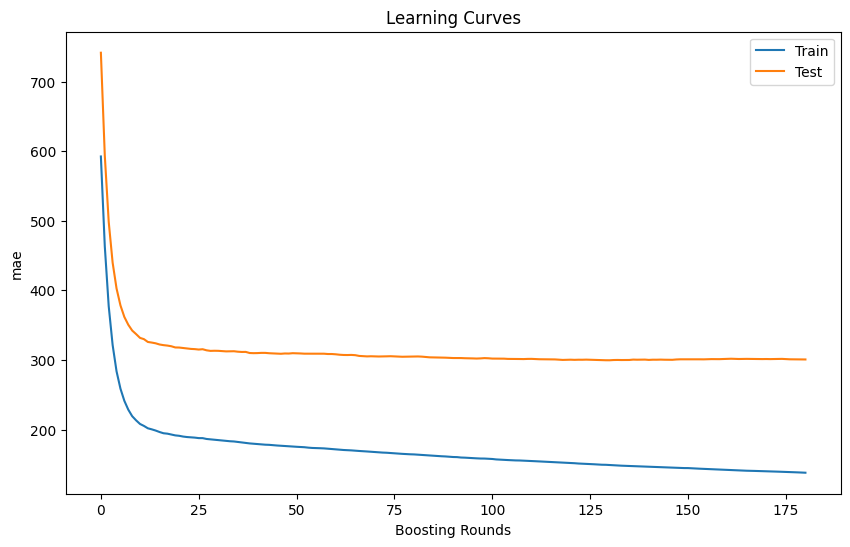

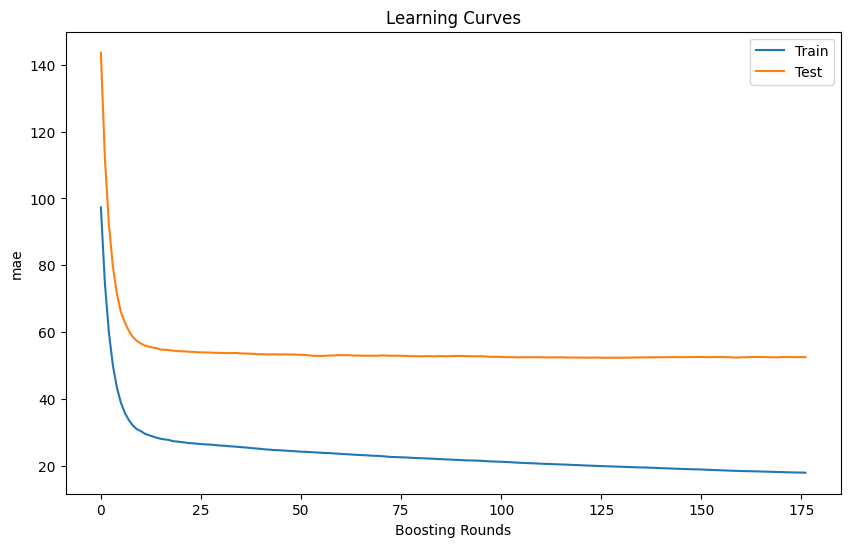

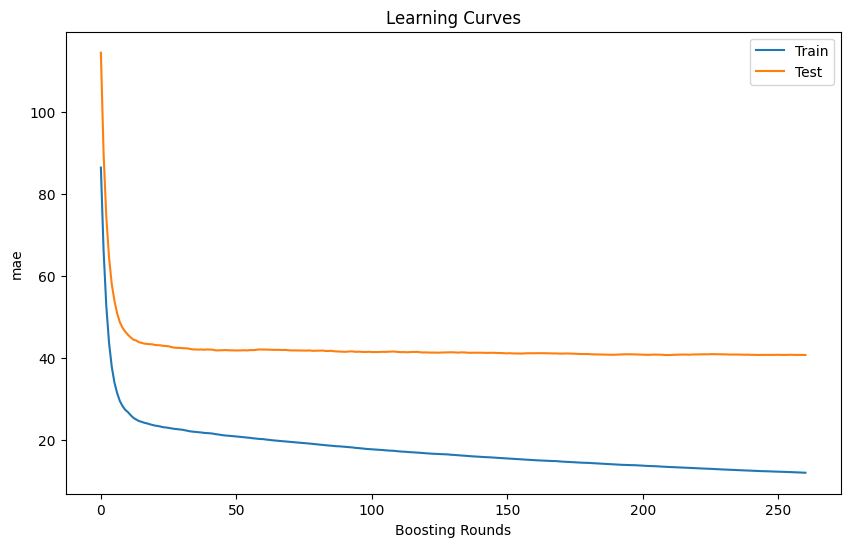

In [147]:
# Créez des listes vides pour stocker les erreurs d'entraînement et de test
train_errors = []
test_errors = []

# Accédez aux erreurs d'entraînement et de test après chaque itération
results = reg_a.evals_result()
train_errors = results['validation_0'][eval_metric]
test_errors = results['validation_1'][eval_metric]

# Tracez les courbes d'apprentissage
plt.figure(figsize=(10, 6))
plt.plot(train_errors, label='Train')
plt.plot(test_errors, label='Test')
plt.xlabel('Boosting Rounds')
plt.ylabel(eval_metric)
plt.legend()
plt.title('Learning Curves')
plt.show()

min_error_a = min(test_errors)
# Créez des listes vides pour stocker les erreurs d'entraînement et de test
train_errors = []
test_errors = []

# Accédez aux erreurs d'entraînement et de test après chaque itération
results = reg_b.evals_result()
train_errors = results['validation_0'][eval_metric]
test_errors = results['validation_1'][eval_metric]

# Tracez les courbes d'apprentissage
plt.figure(figsize=(10, 6))
plt.plot(train_errors, label='Train')
plt.plot(test_errors, label='Test')
plt.xlabel('Boosting Rounds')
plt.ylabel(eval_metric)
plt.legend()
plt.title('Learning Curves')
plt.show()

min_error_b = min(test_errors)
# Créez des listes vides pour stocker les erreurs d'entraînement et de test
train_errors = []
test_errors = []

# Accédez aux erreurs d'entraînement et de test après chaque itération
results = reg_c.evals_result()
train_errors = results['validation_0'][eval_metric]
test_errors = results['validation_1'][eval_metric]

min_error_c = min(test_errors)
# Tracez les courbes d'apprentissage
plt.figure(figsize=(10, 6))
plt.plot(train_errors, label='Train')
plt.plot(test_errors, label='Test')
plt.xlabel('Boosting Rounds')
plt.ylabel(eval_metric)
plt.legend()
plt.title('Learning Curves')
plt.show()

In [148]:
min_error_a, min_error_b, min_error_c

(299.51707391701035, 52.36753247878324, 40.71536667686632)

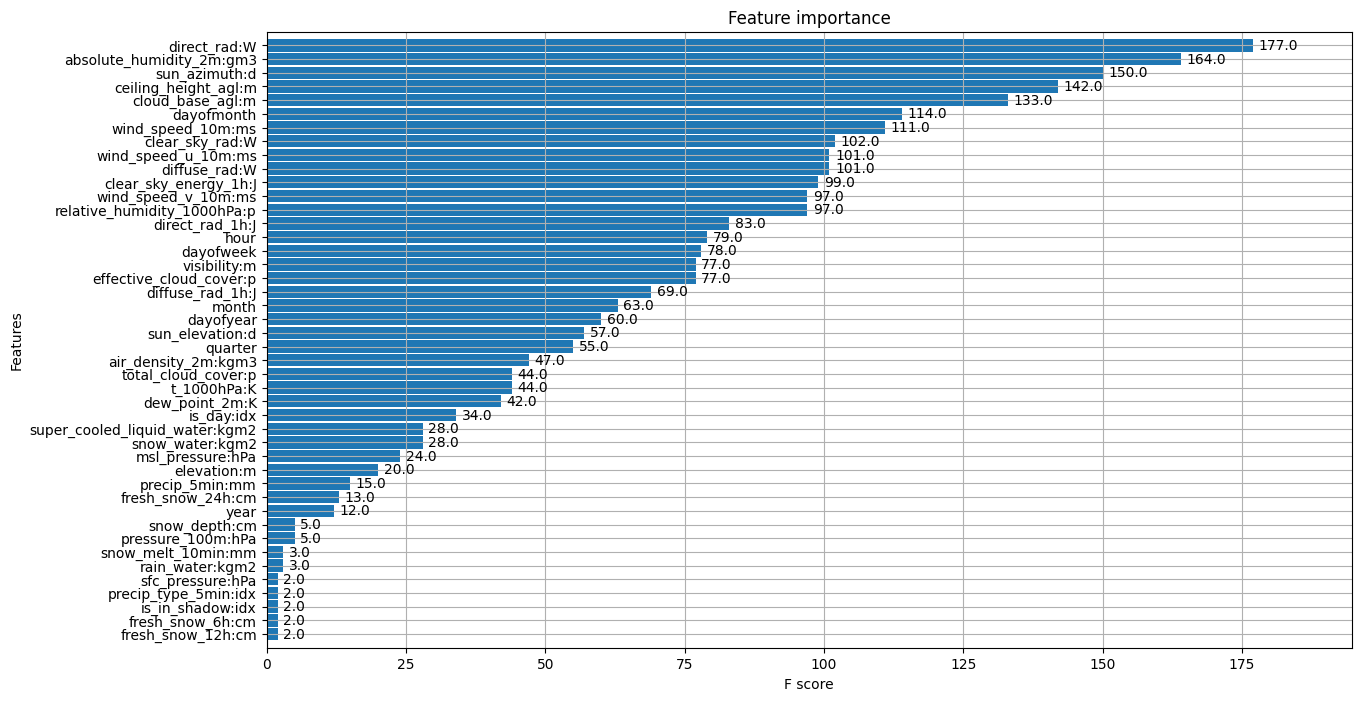

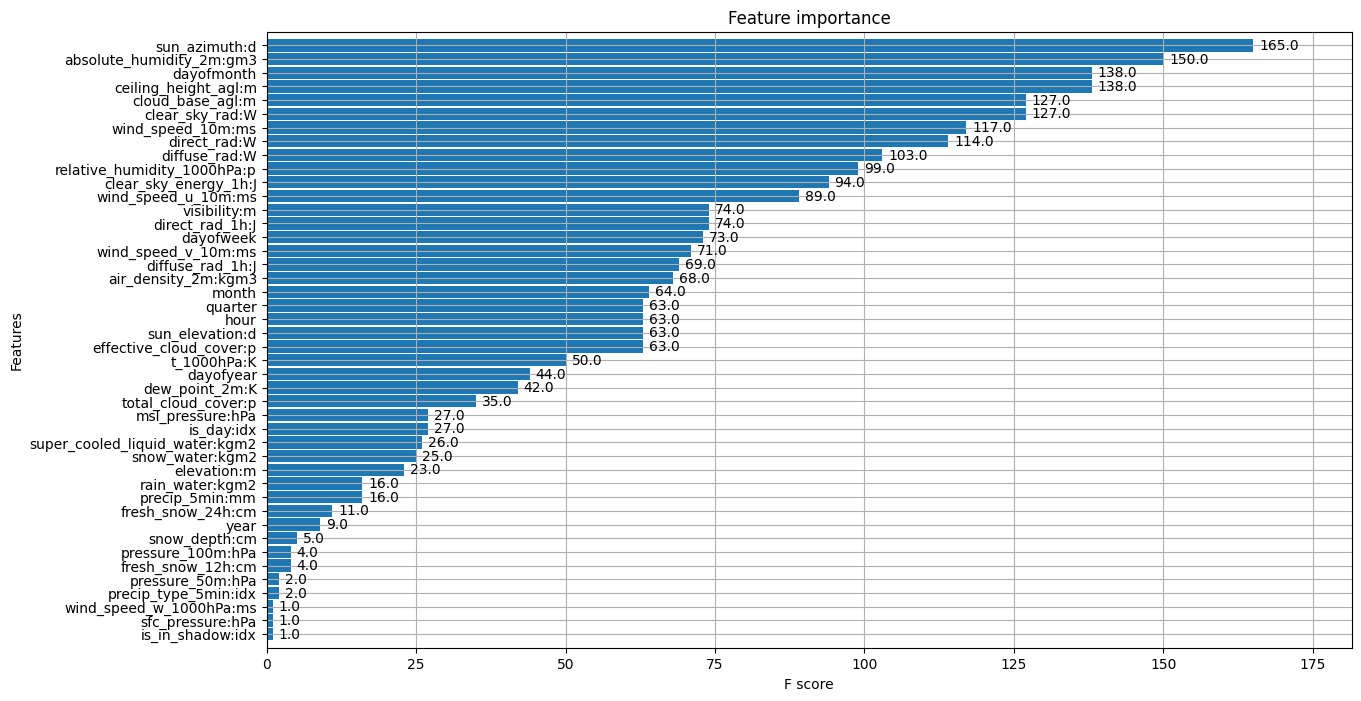

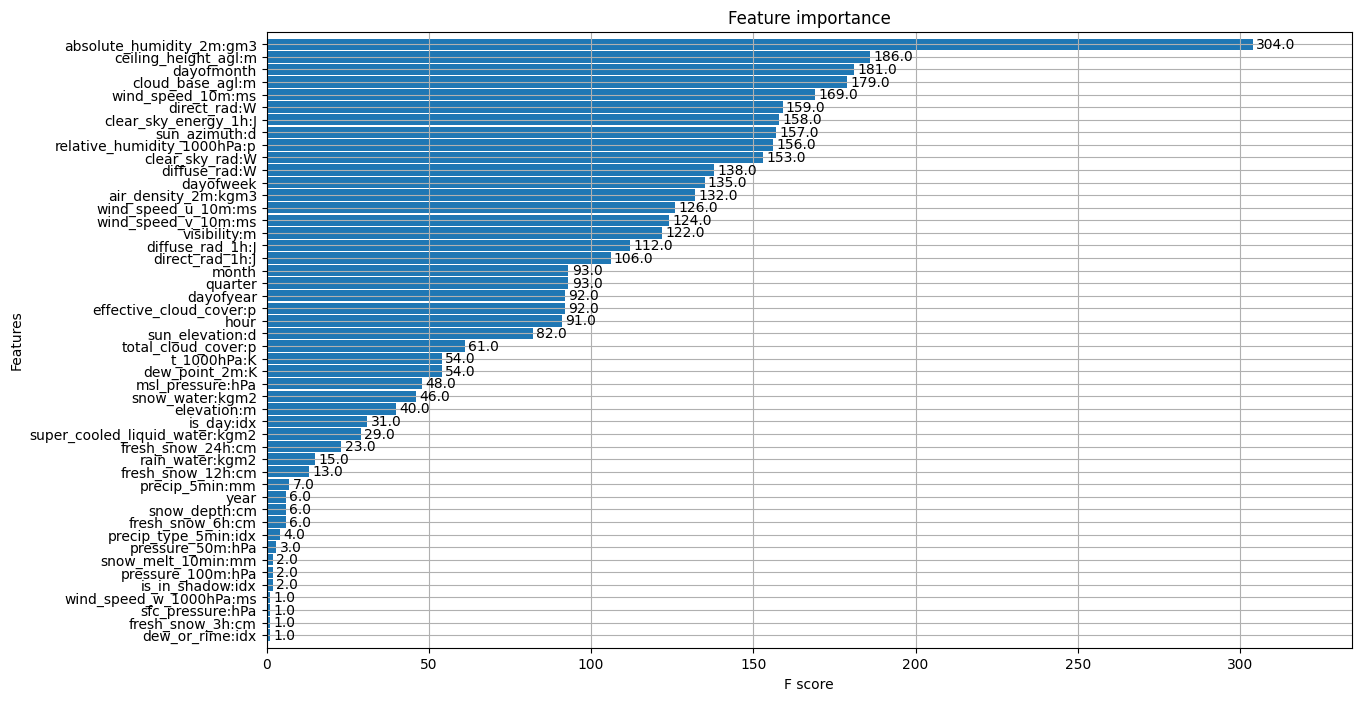

In [149]:
plot_importance(reg_a, height=.9)
plt.gcf().set_size_inches(14, 8)
plot_importance(reg_b, height=0.9)
plt.gcf().set_size_inches(14, 8)
plot_importance(reg_c, height=0.9)
plt.gcf().set_size_inches(14, 8)

In [150]:
pv_test_a['pv_measurement_prediction'] = reg_a.predict(X_test_a_norm)
pv_all_a = pd.concat([pv_test_a, pv_train_a], sort=False)

pv_test_b['pv_measurement_prediction'] = reg_b.predict(X_test_b_norm)
pv_all_b = pd.concat([pv_test_b, pv_train_b], sort=False)

pv_test_c['pv_measurement_prediction'] = reg_c.predict(X_test_c_norm)
pv_all_c = pd.concat([pv_test_c, pv_train_c], sort=False)

In [151]:
pv_test_a[pv_test_a['pv_measurement_prediction'] < 10 ]['pv_measurement_prediction'] = 0.
pv_test_b[pv_test_b['pv_measurement_prediction'] < 10 ]['pv_measurement_prediction'] = 0.
pv_test_c[pv_test_c['pv_measurement_prediction'] < 10 ]['pv_measurement_prediction'] = 0.

/var/folders/dv/nzlg6jm168311nq7f93wfrd80000gn/T/ipykernel_49995/182118369.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pv_test_a[pv_test_a['pv_measurement_prediction'] < 10 ]['pv_measurement_prediction'] = 0.
/var/folders/dv/nzlg6jm168311nq7f93wfrd80000gn/T/ipykernel_49995/182118369.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pv_test_b[pv_test_b['pv_measurement_prediction'] < 10 ]['pv_measurement_prediction'] = 0.
/var/folders/dv/nzlg6jm168311nq7f93wfrd80000gn/T/ipykernel_49995/182118369.py:

In [152]:
mae_a = np.mean(np.abs(pv_all_a['pv_measurement'] - pv_all_a['pv_measurement_prediction']))
mae_b = np.mean(np.abs(pv_all_b['pv_measurement'] - pv_all_b['pv_measurement_prediction']))
mae_c = np.mean(np.abs(pv_all_a['pv_measurement'] - pv_all_c['pv_measurement_prediction']))

df_mae = pd.concat([pv_all_a, pv_all_b, pv_all_a])
mae = np.mean(np.abs(df_mae['pv_measurement'] - df_mae['pv_measurement_prediction']))
print("MAE a:", mae_a, "MAE b:", mae_b, "MAE c:", mae_c)
print("MAE on test set:", mae)

MAE a: 299.51707409249013 MAE b: 52.36753230531781 MAE c: 426.27715055945424
MAE on test set: 229.0326293527245


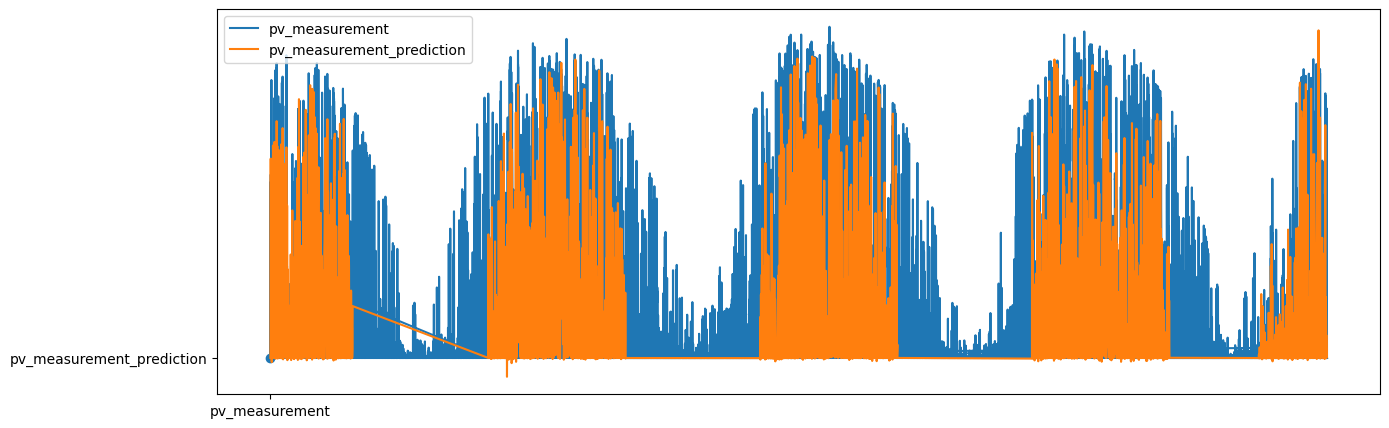

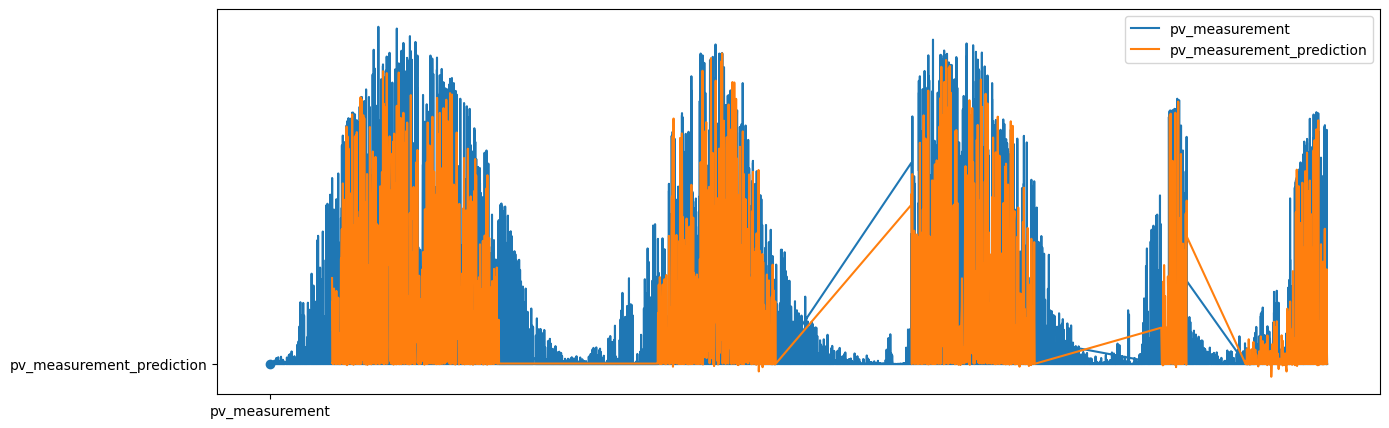

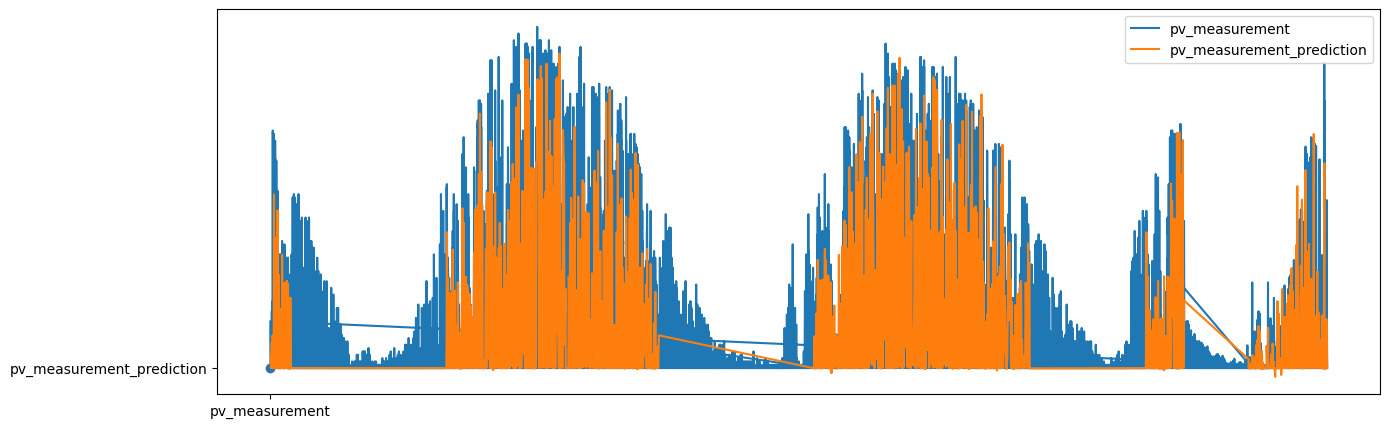

In [153]:
graph = pv_all_a[['pv_measurement','pv_measurement_prediction']].plot(figsize=(15, 5)).scatter('pv_measurement','pv_measurement_prediction')
graph = pv_all_b[['pv_measurement','pv_measurement_prediction']].plot(figsize=(15, 5)).scatter('pv_measurement','pv_measurement_prediction')
graph = pv_all_c[['pv_measurement','pv_measurement_prediction']].plot(figsize=(15, 5)).scatter('pv_measurement','pv_measurement_prediction')

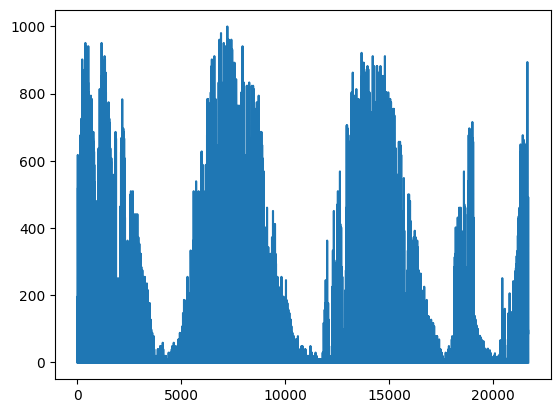

In [154]:
np_pv_c = np.array(pv_all_c['pv_measurement'])
plt.plot(np_pv_c)

# Export sur Kaggle

In [155]:
test = pd.read_csv(path+"test.csv")
test_copy = test.copy()
test.rename(columns={'time': 'date_forecast'}, inplace=True) #pour faire le merge
test["date_forecast"] = pd.to_datetime(test["date_forecast"]) #mettre le bon type

In [156]:
# Lecture des données météo associée :
merged_df_pre_a = pd.merge(X_test_estimated_a, test, on='date_forecast', how='inner')
merged_df_a = merged_df_pre_a[merged_df_pre_a["location"]=="A"]
merged_df_pre_b = pd.merge(X_test_estimated_b, test, on='date_forecast', how='inner')
merged_df_b = merged_df_pre_b[merged_df_pre_b["location"]=="B"]
merged_df_pre_c = pd.merge(X_test_estimated_c, test, on='date_forecast', how='inner')
merged_df_c = merged_df_pre_c[merged_df_pre_c["location"]=="C"]

In [157]:
def preprocessing_test(df,scaler):
  X_test = df.drop(["id","location","prediction"],axis=1)
  X_test = create_features(X_test, None)
  #X_test[('date_forecast')] = X_test[('date_forecast')].values.astype("float64")
  X_test = gestion_nan(X_test)
  X_test = sklearn_z_score_normalize_dataframe(X_test,return_scaler=False,scaler=scaler)
  return X_test

In [158]:
X_test_a_test = preprocessing_test(merged_df_a,scaler_a)
X_test_b_test = preprocessing_test(merged_df_b,scaler_b)
X_test_c_test = preprocessing_test(merged_df_c,scaler_c)

In [159]:
result_A = reg_a.predict(X_test_a_test)
result_B = reg_b.predict(X_test_b_test)
result_C = reg_c.predict(X_test_c_test)

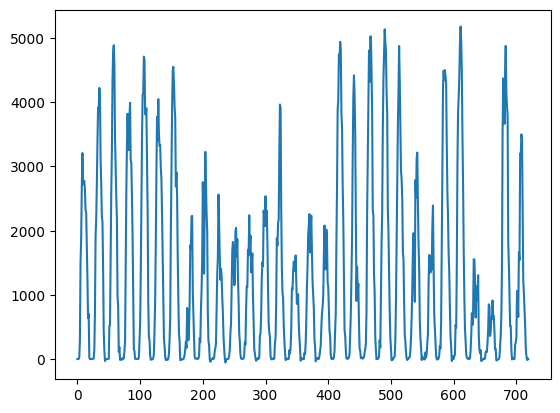

In [160]:
plt.plot(result_A)

In [161]:
nom_fichier = 'XGBoost_Valentin_V2'
repertoire = path
result = np.concatenate((np.concatenate((result_A,result_B)), result_C))
test_copy['prediction'] = result
sample_submission = sample_submission[['id']].merge(test_copy[['id', 'prediction']], on='id', how='left')
sample_submission.to_csv(repertoire+ nom_fichier+'.csv', index=False)

Prochaines amélioration

- mettre un minimum *Done*
- suppression des zones continues en B et C *To DO*
- prise en compte de la date (jour/mois/heure) *Done* peut être ajusté ?
- prendre le meilleur model : celui avec le meilleur score sur le deuxième testset (A : 2,8% B : 5,5%  C: 11,5%) (score eval prévu : 166) --> déjà pris en copmte dans la fonction ...


Perf V1:

A : Test 2 : 446 / 459

B : Test 2 : 101 / 107

C : Test 2 : 68 / 78

Perf V2:

A : Test 1 : 243 | Test 2 : 438 / 455

B : Test 1 : 35 | Test 2 : 106 / 110

C : Test 1 : 26 | Test 2 : 65 / 71

# Post traitement

Ici, on va faire en sorte de n'avoir que des valeurs positives (cela ne représente qu'une légère amélioration

In [162]:
result = np.concatenate((np.concatenate((result_A,result_B)), result_C))

In [163]:
negative_values = result[result < 0]
sum_of_negatives = np.sum(negative_values**2)/len(result)
np.sqrt(sum_of_negatives)

2.5605036649795765

In [164]:
negative_mask = result < 10
result[negative_mask] = 0

In [165]:
nom_fichier = f'XGBoost_separated_loc_n_estimators_{n_estimators}_delta_{delta_title}_min_{scaler_name}_{eval_metric}_max_depth_{max_depth}_mae_{int(mae)}_rmse_{int(min_error_a)}_{int(min_error_b)}_{int(min_error_c)}_rd_sets_{random_state}'
repertoire = submission_path
test_copy['prediction'] = result
sample_submission = sample_submission[['id']].merge(test_copy[['id', 'prediction']], on='id', how='left')
sample_submission.to_csv(repertoire+ nom_fichier+'.csv', index=False)

In [166]:
result2 = np.concatenate((np.concatenate((result_A,result_B)), result_C))

In [167]:
negative_mask2 = result2 < 10
result2[negative_mask2] = 0